# Formula 1 Dataset Analysis (2001~2024)

## Why data from 2001?
Formula 1 cars undergo regulation changes regularly. While regulation change is motivated for the drivers' safety, cost control, and closer competition, it affects the car performance massively - resetting constructor dominance every year.
In 2001, the massive regulation change was introduced - front & rear wing changes, crash standards tightening, driver aids, such as traction control, being reintroduced.   \
Because Formula 1 cars are different year by year, older data from 20th century may be irrelevant. Also, the oldest driver on the current grid, Fernando Alonso, joined Formula 1 in 2001, which makes 2001 a meaningful data. 

### Data
- results: race results, with starting positions and final result.
- races: information of each race
- drivers: information of each driver
- qualifying: information of qualifying session 
- pit_stops: data of pit stops during races
- sprint_results: sprint race results (introduced in 2021)
- constructor_results: race results of the constructor's championship
  

### Loading packages and data

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.read_csv('./data/results.csv', na_values='\\N')
races = pd.read_csv('./data/races.csv', na_values='\\N')
drivers = pd.read_csv('./data/drivers.csv', na_values='\\N')
qualifying = pd.read_csv('./data/qualifying.csv', na_values='\\N')
pit_stops = pd.read_csv('./data/pit_stops.csv', na_values='\\N')
sprint_results = pd.read_csv('./data/sprint_results.csv', na_values='\\N')
constructor_results = pd.read_csv('./data/constructor_results.csv', na_values='\\N')

constructors = pd.read_csv('./data/constructors.csv')

### Clean data

#### Filtering years (2001~2024)   
Note: `raceId` does not represent the order of the race!

In [138]:
# filter year 2001~2024 (start by races.csv because it has year information)
races = races.loc[races['year'].isin(range(2001, 2025))].sort_values(by=['year', 'round']).reset_index(drop=True).sort_values(by=['year', 'round'])
# races.head(5)

valid_raceId = races['raceId'].unique()

# filter year for other datasets
results = results.loc[results['raceId'].isin(valid_raceId)].sort_values(by=['resultId', 'position']).reset_index(drop=True)
# results.head(5)

drivers = drivers.loc[drivers['driverId'].isin(results['driverId'])].sort_values(by='driverId').reset_index(drop=True)
# drivers.head(5)

qualifying = qualifying.loc[qualifying['raceId'].isin(valid_raceId)].sort_values(by=['qualifyId', 'position']).reset_index(drop=True)
qualifying.head(5)

pit_stops['time'] = pd.to_datetime(pit_stops['time'], format='%H:%M:%S').dt.time
# pit_stops.dtypes
pit_stops = pit_stops.loc[pit_stops['raceId'].isin(valid_raceId)].sort_values(by=['time']).reset_index(drop=True)
# pit_stops.head(5)

sprint_results['position'] = sprint_results['position'].astype('Int64') # int64 is used to handle \N (NA) values
sprint_results = sprint_results.loc[sprint_results['raceId'].isin(valid_raceId)].sort_values(by=['resultId', 'position']).reset_index(drop=True)
# sprint_results.dtypes => reveals that 'position' column is not in integer type, hindering the accurate sort order.
# sprint_results.dtypes
# sprint_results.head(10)

constructor_results = constructor_results.loc[constructor_results['raceId'].isin(valid_raceId)].sort_values(by=['constructorResultsId', 'constructorId']).reset_index(drop=True).dropna(axis=1)

#### Checking duplicates (Deduplication)

In [139]:
print(races.duplicated().sum())
print(results.duplicated().sum())
print(drivers.duplicated().sum())
print(qualifying.duplicated().sum())
print(pit_stops.duplicated().sum())
print(sprint_results.duplicated().sum())
print(constructor_results.duplicated().sum())
print(constructors.duplicated().sum())

0
0
0
0
0
0
0
0


Great, it seems there are no duplicates in these data!


### EDA

#### Constructors dominance

In [140]:
races_const_merged = pd.merge(races, constructor_results, on='raceId', how='outer', suffixes=('','_races')).sort_values(by=['year', 'round']).reset_index(drop=True)
races_const_merged = races_const_merged.dropna(axis=1)

constructor_points_sum = races_const_merged.groupby(['year', 'constructorId'])['points'].sum().reset_index().sort_values(by=['year', 'constructorId'])

# Since there are too many constructors, I need to select a few. 
# I choose Ferrari, Renault, Brawn, Redbull, and Mercedes

# Retrieve constructorIds for these teams
selected_const = ['ferrari', 'renault', 'red_bull', 'mercedes', 'brawn', 'mclaren']
selected_const_id = constructors.loc[constructors['constructorRef'].isin(selected_const), ['constructorRef', 'constructorId']].reset_index(drop=True)
selected_const_id

,constructorRef,constructorId
0,mclaren,1
1,renault,4
2,ferrari,6
3,red_bull,9
4,brawn,23
5,mercedes,131


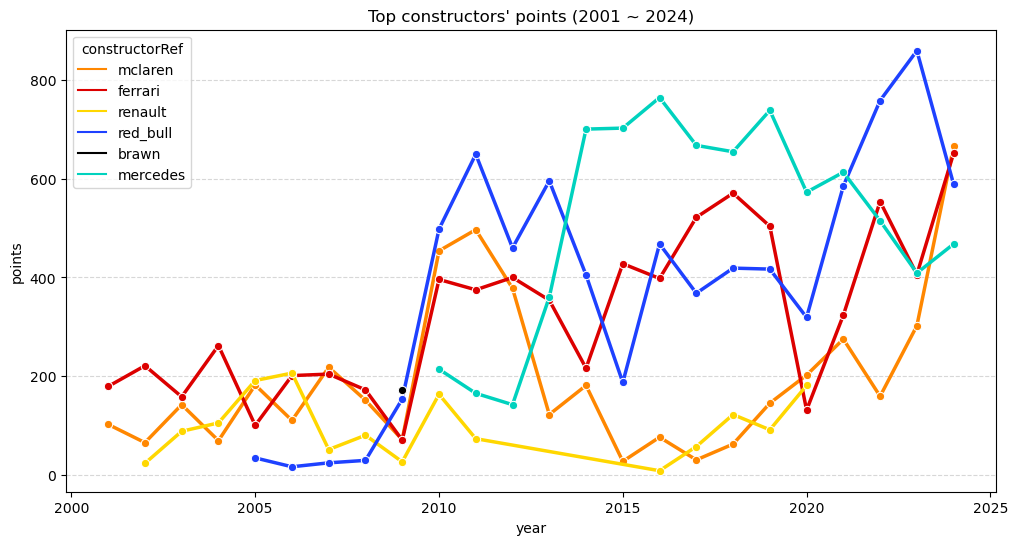

In [141]:
# keep constructors in selected_const_id
constructor_points_sum = constructor_points_sum.loc[constructor_points_sum['constructorId'].isin(selected_const_id['constructorId'])]
# merge selected_const_id and constructor_points_sum on 'constructorId'
constructor_points_sum = constructor_points_sum.merge(selected_const_id, how='left', on='constructorId').sort_values(by=['year', 'constructorId'])

# visualize

custom_color = {
    'mercedes': '#00D2BE',
    'ferrari': '#DC0000',
    'red_bull': '#1E41FF',
    'mclaren': '#FF8700',
    'renault': '#FFD700',
    'brawn': '#000000'
}
plt.figure(figsize=(12, 6))
sns.lineplot(data=constructor_points_sum, x='year', y='points', hue='constructorRef', marker='o', linewidth=2.5, palette=custom_color)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.title("Top constructors' points (2001 ~ 2024)")
plt.show()

- From 2001 to 2009, you can clearly see that Ferrari was dominant, except for 2005 and 2006, when Fernano Alonso (the GOAT) took two championships.  
- Brawn GP (Honda GP until 2008 and Mercedes AMG since 2010) only appeared in 2009.
- From 2010 to 2013, Red Bull Racing was dominant with Sebastian Vettel.
- However, from 2014 to 2021, Mercedes AMG Petronas was very dominant.
- Again, from 2022 to 2023, red bull racing won the constructors championship.
- At the end of the graph, you can see Red Bull Racing's rapid drop in performance, which is still undergoing. 
- Mclaren's recent performance is impressive. Before 2021, Mclaren used Honda Engine and underperformed. They were able to turn the table after agreement with Mercedes on the usage of their engine. Mclaren's performance is still mind-blowing to this day (2025).

### Qualifying positions and race result correlation

In [147]:
qual_race_merged = qualifying.merge(
    results,
    on=['raceId', 'driverId', 'constructorId'],
    suffixes=('_qualifying, _race')
)
qual_race_merged.head(10)

C:\Users\mrkoh\AppData\Local\Temp\ipykernel_21520\91491990.py:1: FutureWarning: Passing 'suffixes' as a <class 'str'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  qual_race_merged = qualifying.merge(


ValueError: too many values to unpack (expected 2)